<a href="https://colab.research.google.com/github/eg-jamessmith/gnn-learnings/blob/main/deepwalk_and_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Representations with DeepWalk

From the book - Hands-On GNN's with Python

In [34]:
import numpy as np
import string
np.random.seed(0)

CONTEXT_SIZE = 2

# from GPT4
raw_text = """Node2Vec is an algorithm designed to produce vector embeddings for
nodes in a graph, inspired by the Word2Vec approach used for word embeddings
in natural language processing. Just as Word2Vec captures semantic relationships
between words by considering their co-occurrence patterns within a moving
window in sentences, Node2Vec captures structural and functional roles of nodes
in a graph by considering their connectivity patterns. In Word2Vec, words
appearing in similar contexts (i.e., nearby in sentences) tend to have similar
embeddings. Similarly, in Node2Vec, nodes that have similar neighborhoods or
roles in the graph tend to have similar embeddings.

To achieve this, Node2Vec uses random walks on the graph to simulate the
equivalent of "sentences" for nodes. By exploring various contexts in which
a node appears during these walks, the algorithm learns a dense vector
representation for each node. These random walks are influenced by two
parameters, p and q, which guide the exploration in a biased manner to either
prioritize breadth-first or depth-first sampling. This is somewhat analogous
to adjusting the window size in Word2Vec. Once these walks are generated,
they are fed into a skip-gram model (similar to Word2Vec) to generate
embeddings, capturing both local and global graph structures."""

text = ''.join([char for char in raw_text if char not in string.punctuation]).lower().split()

In [35]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 107


In [36]:
import networkx as nx
import matplotlib.pyplot as plt


def text_to_graph(words):
    # assumes text is already split
    G = nx.DiGraph()  # Create a directed graph

    for i in range(len(words) - 1):
        # If the edge already exists, we'll simply increase the weight (indicating it's more common)
        if G.has_edge(words[i], words[i+1]):
            G[words[i]][words[i+1]]['weight'] += 1
        else:
            G.add_edge(words[i], words[i+1], weight=1)

    return G

G_text = text_to_graph(text)

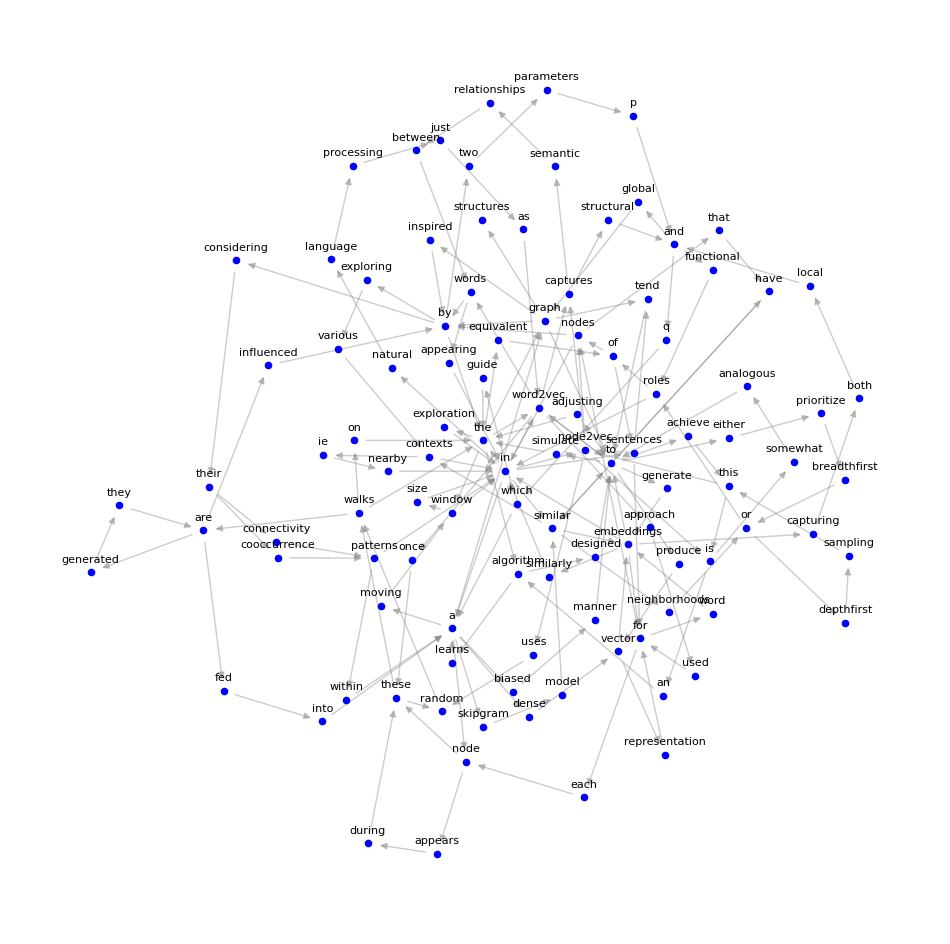

In [38]:
# Plot graph
plt.figure(figsize=(12, 12))
plt.axis('off')

node_color = 'blue'
font_color = 'black'
edge_color = 'gray'
edge_alpha = 0.4
font_size = 8
node_size = 20

pos = nx.kamada_kawai_layout(
    G_text,
    # seed=0,
    scale=2
    )

# Create a new dictionary for label positions with adjusted y-coordinates
label_pos = {node: (coords[0], coords[1] + 0.05) for node, coords in pos.items()}

nx.draw_networkx_nodes(G_text, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G_text, pos, edge_color=edge_color, alpha=edge_alpha)
nx.draw_networkx_labels(G_text, label_pos, font_size=font_size, font_color=font_color)

plt.show()

In [39]:
# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])

[('an', ['node2vec', 'is', 'algorithm', 'designed']), ('algorithm', ['is', 'an', 'designed', 'to'])]


In [40]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec(
    [text],
    sg=1,   # Skip-gram
    vector_size=10,
    min_count=0,
    window=2,
    workers=1,
    seed=0
)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Train model
model.train([text], total_examples=model.corpus_count, epochs=10)

# Print a word embedding
print('\nWord embedding for "embeddings" =')
print(model.wv['embeddings'])

Shape of W_embed: (107, 10)

Word embedding for "embeddings" =
[ 0.03380066  0.01994759 -0.04851602 -0.03642501  0.04674775  0.02975925
 -0.00477972 -0.03432924  0.05365494 -0.01846312]


In [41]:
# Get the most similar words for "example"
similar_words = model.wv.most_similar("embeddings", topn=2)

# Print the similar words along with their cosine similarities
print('\nMost similar words to "embeddings" =')
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


Most similar words to "embeddings" =
walks: 0.7089883685112
their: 0.6941626071929932
